In [1]:
import warnings
import pandas as pd
import xgboost as xgb
import codes.utils as utils
DATA_PATH = 'data/internal_training_data/'

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
# Load processed CUP data
onconpc_processed_cups_df = pd.read_csv('data/onconpc_processed_cups_data.csv', index_col='RANDID')

# Load fully trained OncoNPC model
xgb_onconpc = xgb.Booster()
xgb_onconpc.load_model('model/xgboost_v1.7.6_OncoNPC_full.json')

# Specify cancer types to consider
cancer_types_to_consider = ['Acute Myeloid Leukemia', 'Bladder Urothelial Carcinoma', 'Cholangiocarcinoma',
                            'Colorectal Adenocarcinoma', 'Diffuse Glioma', 'Endometrial Carcinoma',
                            'Esophagogastric Adenocarcinoma', 'Gastrointestinal Neuroendocrine Tumors', 'Gastrointestinal Stromal Tumor',
                            'Head and Neck Squamous Cell Carcinoma', 'Invasive Breast Carcinoma', 'Melanoma', 'Meningothelial Tumor',
                            'Non-Hodgkin Lymphoma', 'Non-Small Cell Lung Cancer', 'Ovarian Epithelial Tumor', 'Pancreatic Adenocarcinoma',
                            'Pancreatic Neuroendocrine Tumor', 'Pleural Mesothelioma', 'Prostate Adenocarcinoma', 'Renal Cell Carcinoma',
                            'Well-Differentiated Thyroid Cancer']
# Predict primary sites of CUP tumors
cup_preds_df = utils.get_xgboost_latest_cancer_type_preds(xgb_onconpc,
                                                          onconpc_processed_cups_df,
                                                          cancer_types_to_consider)

In [3]:
# Get SHAP values for CUP tumors
warnings.filterwarnings('ignore')
shaps_cup = utils.obtain_shap_values_with_latest_xgboost(xgb_onconpc, onconpc_processed_cups_df)

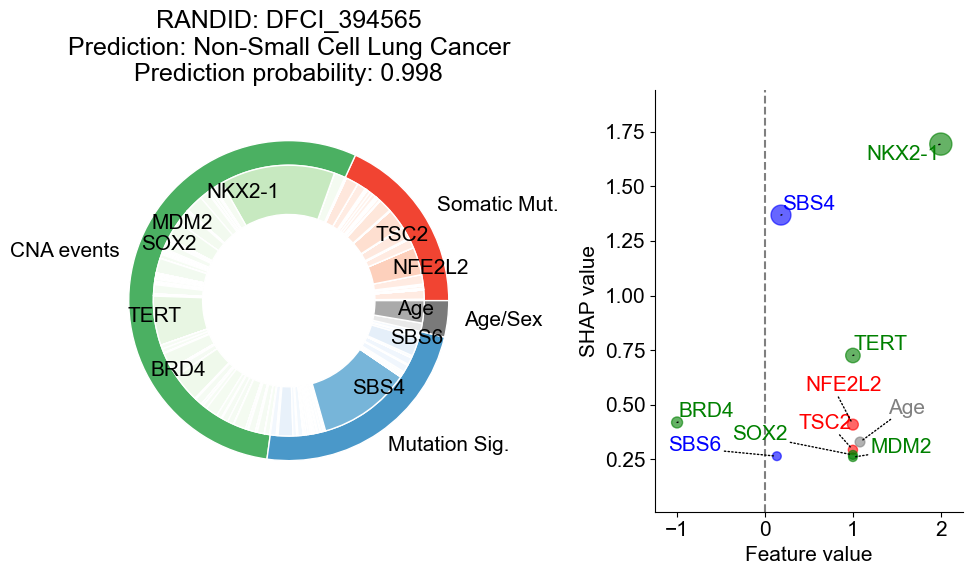

In [4]:
# Specify query tumor sample ID
query_randid = 'DFCI_394565'

# Get OncoNPC prediction
pred_prob = cup_preds_df.at[query_randid, 'max_posterior']
pred_cancer = cup_preds_df.at[query_randid, 'cancer_type']
pred_cancer_idx = cancer_types_to_consider.index(pred_cancer)

# Get SHAP-based explanation for the prediction
feature_sample_df = onconpc_processed_cups_df.loc[query_randid]
shap_pred_cancer_df = pd.DataFrame(shaps_cup[pred_cancer_idx],
                                   index=onconpc_processed_cups_df.index,
                                   columns=onconpc_processed_cups_df.columns)
shap_pred_sample_df = shap_pred_cancer_df.loc[query_randid]

# Generate explanation plot
sample_info = f'RANDID: {query_randid}\nPrediction: {pred_cancer}\nPrediction probability: {pred_prob:.3f}'
feature_group_to_features_dict = utils.partiton_feature_names_by_group(onconpc_processed_cups_df.columns)
utils.get_individual_pred_interpretation(shap_pred_sample_df, feature_sample_df, feature_group_to_features_dict,
                                         sample_info=sample_info)